In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
from sklearn import metrics
from collections import Counter
import datetime
from sklearn.metrics import mean_squared_error
from plotly import tools
import plotly.graph_objs as go
from datetime import date, timedelta, datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot

%run ../../UtilityPython.ipynb

Using TensorFlow backend.


In [4]:
#Preleva il dataset per la provincia di interesse

def dataset_per_country_code(df, prov):
    df_prov = df[df['PROVINCIA']==prov]
    df_prov.drop('PROVINCIA', axis=1, inplace=True)
    df_prov.set_index('DATA',inplace=True)
    df_prov=df_prov.asfreq('3H').reset_index()
    df_prov.set_index('DATA',inplace=True)
    dfprov = df[df['PROVINCIA']==prov]
    dfprov['DATA']=pd.DatetimeIndex(dfprov['DATA'])
    dfprov.drop('PROVINCIA', axis=1, inplace=True)
    dfprov.set_index('DATA',inplace=True)
    df_final=pd.merge(dfprov, df_prov['TIPO_GIORNO_DS'], left_index=True, right_index=True, how='outer')
    df_final.drop('TIPO_GIORNO_DS_y', axis=1, inplace=True)
    df_final.rename(columns={'TIPO_GIORNO_DS_x' : 'TIPO_GIORNO_DS'}, inplace=True)
    df_final[['MAX_DS','SOPRA_SOGLIA_GIALLA','SOPRA_SOGLIA_ROSSA', 'SOPRA_CAPACITA', 'N_APPARATI','KPI']]=df_final[['MAX_DS','SOPRA_SOGLIA_GIALLA','SOPRA_SOGLIA_ROSSA', 'SOPRA_CAPACITA', 'N_APPARATI','KPI']].fillna(0)
    df_final[['TIPO_GIORNO_DS']]=df_final[['TIPO_GIORNO_DS']].fillna(method='ffill')
    df_final['PRED'] = df_final['MAX_DS'].shift(-1)
    df_final.PRED.fillna(0, inplace=True)
    print(df_final.MAX_DS.min())
    print(df_final.MAX_DS.max())
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    df_scal = pd.DataFrame(feature_scaler.fit_transform(df_final),
                           index=df_final.index, columns=df_final.columns)
    return df_scal

In [5]:
#Splitta il dataset in train, validation e test
def split_dataset(df):
    print("Data iniziale: " + str(datetime.strftime(df.index.min().date(), '%d-%m-%Y')))
    print("Data finale: " + str(datetime.strftime(df.index.max().date(), '%d-%m-%Y')))
    delta=df.index.max().date()-df.index.min().date()
    # split into train and test sets
    values = df.values
    n_train_3hours =  int(delta.days * 8 * 0.85)
    train_val = values[:n_train_3hours, :]
    test = values[n_train_3hours:, :]

    #split into train and validation sets
    n_validate_3hours = int(n_train_3hours * 0.9)
    train = train_val[:n_validate_3hours, :]
    val = train_val[n_validate_3hours:, :]

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    val_X, val_y = val[:, :-1], val[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
    
    #Manteniamo gli indici per plottare successivamente il test set
    indexs = df.index
    add=timedelta(hours=3)
    test_indexs = indexs[n_train_3hours:]+add
    
    return train_X, train_y, val_X, val_y, test_X, test_y, test_indexs

In [6]:
def model_lstm(train_X,train_y,val_X, val_y):
    model = Sequential()
    model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units=200, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=200, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=200, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=200, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    #10000 72
    return model.fit(train_X, train_y, epochs=1000, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False),model

def print_result(test_X, test_y, model, history):
    yhat = model.predict(test_X)
    rmse = np.sqrt(mean_squared_error(test_y, yhat))
    mse = mean_squared_error(test_y, yhat)
    print('Test RMSE: %.3f' % rmse)
    print('Test MSE: %.3f' % mse)

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

In [7]:
def print_time_series_predicted(test_y, test_indexs, yhat, yhat2, prov):
    test_y_df = pd.DataFrame(test_y,index=test_indexs, columns=['VALUE'])
    yhat_df = pd.DataFrame(yhat, index=test_indexs, columns=['VALUE'])
    yhat_df2 = pd.DataFrame(yhat2, index=test_indexs, columns=['VALUE'])

    trace1 = go.Scatter(x = test_y_df.index, y = test_y_df.VALUE, name = "Atteso", line = dict(color = '#17BECF'), opacity = 0.8)
    trace2 = go.Scatter(x = yhat_df.index ,y = yhat_df.VALUE, name = "Predetto", line = dict(color = '#7F7F7F'), opacity = 0.8)
    trace3 = go.Scatter(x = yhat_df2.index ,y = yhat_df2.VALUE, name = "Predetto", line = dict(color = '#7F7F7F'), opacity = 0.8)

    fig = tools.make_subplots(rows=2, cols=1, specs=[[{}],[{}]])

    fig.append_trace(trace1, 1,1)
    fig.append_trace(trace2, 1,1)
    fig.append_trace(trace1, 2,1)
    fig.append_trace(trace3, 2,1)

    fig['layout'].update( height=900,title='Time Series Atteso / Predetto con KPI ' + prov, showlegend=True)

    fig.show()

In [7]:
df = pd.read_csv('./datasets/to_train.csv', keep_default_na=False, na_values=['_'])
df.drop('REGIONE',axis=1,inplace=True)
df_na=dataset_per_country_code(df,'NA')
train_X, train_y, val_X, val_y, test_X, test_y, test_indexs=split_dataset(df_na)
lstm_hist, lstm_model=model_lstm(train_X,train_y,val_X, val_y)

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.0
34233.7292
Data iniziale: 07-10-2019
Data finale: 02-02-2020
(721, 1, 7) (721,) (81, 1, 7) (81,) (150, 1, 7) (150,)
Train on 721 samples, validate on 81 samples
Epoch 1/1000
 - 2s - loss: 0.1077 - val_loss: 0.1087
Epoch 2/1000
 - 0s - loss: 0.1075 - val_loss: 0.1085
Epoch 3/1000
 - 0s - loss: 0.1075 - val_loss: 0.1088
Epoch 4/1000
 - 0s - loss: 0.1077 - val_loss: 0.1089
Epoch 5/1000
 - 0s - loss: 0.1077 - val_loss: 0.1088
Epoch 6/1000
 - 0s - loss: 0.1077 - val_loss: 0.1087
Epoch 7/1000
 - 0s - loss: 0.1076 - val_loss: 0.1087
Epoch 8/1000
 - 0s - loss: 0.1077 - val_loss: 0.1088
Epoch 9/1000
 - 0s - loss: 0.1076 - val_loss: 0.1088
Epoch 10/1000
 - 0s - loss: 0.1076 - val_loss: 0.1088
Epoch 11/1000
 - 0s - loss: 0.1077 - val_loss: 0.1087
Epoch 12/1000
 - 0s - loss: 0.1076 - val_loss: 0.1086
Epoch 13/1000
 - 0s - loss: 0.1075 - val_loss: 0.1085
Epoch 14/1000
 - 0s - loss: 0.1073 - val_loss: 0.1082
Epoch 15/1000
 - 0s - loss: 0.1070 - val_loss: 0.1080
Epoch 16/1000
 - 0s - loss: 0.1065

Epoch 149/1000
 - 0s - loss: 0.0608 - val_loss: 0.0481
Epoch 150/1000
 - 0s - loss: 0.0608 - val_loss: 0.0481
Epoch 151/1000
 - 0s - loss: 0.0606 - val_loss: 0.0464
Epoch 152/1000
 - 0s - loss: 0.0592 - val_loss: 0.0469
Epoch 153/1000
 - 0s - loss: 0.0606 - val_loss: 0.0470
Epoch 154/1000
 - 0s - loss: 0.0617 - val_loss: 0.0486
Epoch 155/1000
 - 0s - loss: 0.0591 - val_loss: 0.0461
Epoch 156/1000
 - 0s - loss: 0.0633 - val_loss: 0.0488
Epoch 157/1000
 - 0s - loss: 0.0633 - val_loss: 0.0501
Epoch 158/1000
 - 0s - loss: 0.0628 - val_loss: 0.0494
Epoch 159/1000
 - 0s - loss: 0.0608 - val_loss: 0.0485
Epoch 160/1000
 - 0s - loss: 0.0612 - val_loss: 0.0500
Epoch 161/1000
 - 0s - loss: 0.0603 - val_loss: 0.0443
Epoch 162/1000
 - 0s - loss: 0.0607 - val_loss: 0.0468
Epoch 163/1000
 - 0s - loss: 0.0637 - val_loss: 0.0488
Epoch 164/1000
 - 0s - loss: 0.0601 - val_loss: 0.0459
Epoch 165/1000
 - 0s - loss: 0.0610 - val_loss: 0.0471
Epoch 166/1000
 - 0s - loss: 0.0594 - val_loss: 0.0470
Epoch 167/

Epoch 298/1000
 - 0s - loss: 0.0588 - val_loss: 0.0416
Epoch 299/1000
 - 0s - loss: 0.0581 - val_loss: 0.0494
Epoch 300/1000
 - 0s - loss: 0.0583 - val_loss: 0.0442
Epoch 301/1000
 - 0s - loss: 0.0595 - val_loss: 0.0451
Epoch 302/1000
 - 0s - loss: 0.0564 - val_loss: 0.0413
Epoch 303/1000
 - 0s - loss: 0.0577 - val_loss: 0.0455
Epoch 304/1000
 - 0s - loss: 0.0569 - val_loss: 0.0425
Epoch 305/1000
 - 0s - loss: 0.0568 - val_loss: 0.0488
Epoch 306/1000
 - 0s - loss: 0.0573 - val_loss: 0.0424
Epoch 307/1000
 - 0s - loss: 0.0602 - val_loss: 0.0485
Epoch 308/1000
 - 0s - loss: 0.0582 - val_loss: 0.0422
Epoch 309/1000
 - 0s - loss: 0.0600 - val_loss: 0.0476
Epoch 310/1000
 - 0s - loss: 0.0574 - val_loss: 0.0430
Epoch 311/1000
 - 0s - loss: 0.0564 - val_loss: 0.0445
Epoch 312/1000
 - 0s - loss: 0.0603 - val_loss: 0.0449
Epoch 313/1000
 - 0s - loss: 0.0556 - val_loss: 0.0437
Epoch 314/1000
 - 0s - loss: 0.0589 - val_loss: 0.0434
Epoch 315/1000
 - 0s - loss: 0.0557 - val_loss: 0.0429
Epoch 316/

Epoch 447/1000
 - 0s - loss: 0.0580 - val_loss: 0.0448
Epoch 448/1000
 - 0s - loss: 0.0578 - val_loss: 0.0444
Epoch 449/1000
 - 0s - loss: 0.0575 - val_loss: 0.0446
Epoch 450/1000
 - 0s - loss: 0.0569 - val_loss: 0.0439
Epoch 451/1000
 - 0s - loss: 0.0553 - val_loss: 0.0473
Epoch 452/1000
 - 0s - loss: 0.0583 - val_loss: 0.0468
Epoch 453/1000
 - 0s - loss: 0.0578 - val_loss: 0.0421
Epoch 454/1000
 - 0s - loss: 0.0558 - val_loss: 0.0453
Epoch 455/1000
 - 0s - loss: 0.0556 - val_loss: 0.0418
Epoch 456/1000
 - 0s - loss: 0.0589 - val_loss: 0.0452
Epoch 457/1000
 - 0s - loss: 0.0588 - val_loss: 0.0456
Epoch 458/1000
 - 0s - loss: 0.0565 - val_loss: 0.0423
Epoch 459/1000
 - 0s - loss: 0.0550 - val_loss: 0.0424
Epoch 460/1000
 - 0s - loss: 0.0549 - val_loss: 0.0442
Epoch 461/1000
 - 0s - loss: 0.0574 - val_loss: 0.0445
Epoch 462/1000
 - 0s - loss: 0.0557 - val_loss: 0.0423
Epoch 463/1000
 - 0s - loss: 0.0548 - val_loss: 0.0437
Epoch 464/1000
 - 0s - loss: 0.0548 - val_loss: 0.0433
Epoch 465/

Epoch 596/1000
 - 0s - loss: 0.0548 - val_loss: 0.0416
Epoch 597/1000
 - 0s - loss: 0.0545 - val_loss: 0.0440
Epoch 598/1000
 - 0s - loss: 0.0544 - val_loss: 0.0441
Epoch 599/1000
 - 0s - loss: 0.0536 - val_loss: 0.0415
Epoch 600/1000
 - 0s - loss: 0.0540 - val_loss: 0.0438
Epoch 601/1000
 - 0s - loss: 0.0535 - val_loss: 0.0404
Epoch 602/1000
 - 0s - loss: 0.0545 - val_loss: 0.0471
Epoch 603/1000
 - 0s - loss: 0.0531 - val_loss: 0.0417
Epoch 604/1000
 - 0s - loss: 0.0550 - val_loss: 0.0408
Epoch 605/1000
 - 0s - loss: 0.0548 - val_loss: 0.0468
Epoch 606/1000
 - 0s - loss: 0.0543 - val_loss: 0.0417
Epoch 607/1000
 - 0s - loss: 0.0547 - val_loss: 0.0422
Epoch 608/1000
 - 0s - loss: 0.0554 - val_loss: 0.0400
Epoch 609/1000
 - 0s - loss: 0.0560 - val_loss: 0.0426
Epoch 610/1000
 - 0s - loss: 0.0542 - val_loss: 0.0410
Epoch 611/1000
 - 0s - loss: 0.0541 - val_loss: 0.0421
Epoch 612/1000
 - 0s - loss: 0.0542 - val_loss: 0.0421
Epoch 613/1000
 - 0s - loss: 0.0550 - val_loss: 0.0400
Epoch 614/

Epoch 745/1000
 - 0s - loss: 0.0524 - val_loss: 0.0417
Epoch 746/1000
 - 0s - loss: 0.0544 - val_loss: 0.0423
Epoch 747/1000
 - 0s - loss: 0.0532 - val_loss: 0.0406
Epoch 748/1000
 - 0s - loss: 0.0532 - val_loss: 0.0384
Epoch 749/1000
 - 0s - loss: 0.0546 - val_loss: 0.0429
Epoch 750/1000
 - 0s - loss: 0.0543 - val_loss: 0.0443
Epoch 751/1000
 - 0s - loss: 0.0559 - val_loss: 0.0439
Epoch 752/1000
 - 0s - loss: 0.0537 - val_loss: 0.0407
Epoch 753/1000
 - 0s - loss: 0.0540 - val_loss: 0.0407
Epoch 754/1000
 - 0s - loss: 0.0537 - val_loss: 0.0407
Epoch 755/1000
 - 0s - loss: 0.0542 - val_loss: 0.0417
Epoch 756/1000
 - 0s - loss: 0.0541 - val_loss: 0.0387
Epoch 757/1000
 - 0s - loss: 0.0539 - val_loss: 0.0451
Epoch 758/1000
 - 0s - loss: 0.0535 - val_loss: 0.0413
Epoch 759/1000
 - 0s - loss: 0.0557 - val_loss: 0.0462
Epoch 760/1000
 - 0s - loss: 0.0538 - val_loss: 0.0426
Epoch 761/1000
 - 0s - loss: 0.0535 - val_loss: 0.0396
Epoch 762/1000
 - 0s - loss: 0.0543 - val_loss: 0.0413
Epoch 763/

Epoch 894/1000
 - 0s - loss: 0.0521 - val_loss: 0.0391
Epoch 895/1000
 - 0s - loss: 0.0536 - val_loss: 0.0402
Epoch 896/1000
 - 0s - loss: 0.0525 - val_loss: 0.0408
Epoch 897/1000
 - 0s - loss: 0.0522 - val_loss: 0.0393
Epoch 898/1000
 - 0s - loss: 0.0539 - val_loss: 0.0407
Epoch 899/1000
 - 0s - loss: 0.0539 - val_loss: 0.0395
Epoch 900/1000
 - 0s - loss: 0.0523 - val_loss: 0.0433
Epoch 901/1000
 - 0s - loss: 0.0529 - val_loss: 0.0386
Epoch 902/1000
 - 0s - loss: 0.0544 - val_loss: 0.0406
Epoch 903/1000
 - 0s - loss: 0.0549 - val_loss: 0.0437
Epoch 904/1000
 - 0s - loss: 0.0533 - val_loss: 0.0410
Epoch 905/1000
 - 0s - loss: 0.0531 - val_loss: 0.0401
Epoch 906/1000
 - 0s - loss: 0.0535 - val_loss: 0.0425
Epoch 907/1000
 - 0s - loss: 0.0527 - val_loss: 0.0426
Epoch 908/1000
 - 0s - loss: 0.0508 - val_loss: 0.0405
Epoch 909/1000
 - 0s - loss: 0.0516 - val_loss: 0.0419
Epoch 910/1000
 - 0s - loss: 0.0539 - val_loss: 0.0415
Epoch 911/1000
 - 0s - loss: 0.0522 - val_loss: 0.0399
Epoch 912/

Test RMSE: 0.094
Test MSE: 0.009


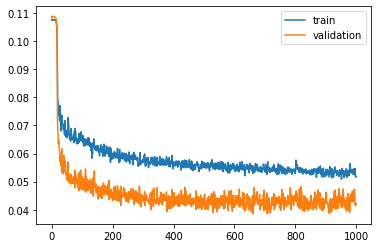

In [8]:
print_result(test_X, test_y, lstm_model, lstm_hist)

In [9]:
#Trainiamo il modello senza il KPI 
df_na_nokpi=df_na.drop(['KPI'], axis=1)
train_X2, train_y2, val_X2, val_y2, test_X2, test_y2, test_indexs2=split_dataset(df_na_nokpi)
lstm_hist2, lstm_model2=model_lstm(train_X2,train_y2,val_X2, val_y2)

Data iniziale: 07-10-2019
Data finale: 02-02-2020
(721, 1, 6) (721,) (81, 1, 6) (81,) (150, 1, 6) (150,)
Train on 721 samples, validate on 81 samples
Epoch 1/1000
 - 2s - loss: 0.1076 - val_loss: 0.1087
Epoch 2/1000
 - 0s - loss: 0.1074 - val_loss: 0.1085
Epoch 3/1000
 - 0s - loss: 0.1076 - val_loss: 0.1089
Epoch 4/1000
 - 0s - loss: 0.1078 - val_loss: 0.1089
Epoch 5/1000
 - 0s - loss: 0.1076 - val_loss: 0.1087
Epoch 6/1000
 - 0s - loss: 0.1076 - val_loss: 0.1086
Epoch 7/1000
 - 0s - loss: 0.1076 - val_loss: 0.1088
Epoch 8/1000
 - 0s - loss: 0.1077 - val_loss: 0.1089
Epoch 9/1000
 - 0s - loss: 0.1077 - val_loss: 0.1089
Epoch 10/1000
 - 0s - loss: 0.1076 - val_loss: 0.1088
Epoch 11/1000
 - 0s - loss: 0.1076 - val_loss: 0.1087
Epoch 12/1000
 - 0s - loss: 0.1076 - val_loss: 0.1087
Epoch 13/1000
 - 0s - loss: 0.1076 - val_loss: 0.1087
Epoch 14/1000
 - 0s - loss: 0.1076 - val_loss: 0.1088
Epoch 15/1000
 - 0s - loss: 0.1077 - val_loss: 0.1088
Epoch 16/1000
 - 0s - loss: 0.1076 - val_loss: 0.

 - 0s - loss: 0.0679 - val_loss: 0.0574
Epoch 150/1000
 - 0s - loss: 0.0691 - val_loss: 0.0581
Epoch 151/1000
 - 0s - loss: 0.0699 - val_loss: 0.0579
Epoch 152/1000
 - 0s - loss: 0.0695 - val_loss: 0.0561
Epoch 153/1000
 - 0s - loss: 0.0679 - val_loss: 0.0567
Epoch 154/1000
 - 0s - loss: 0.0680 - val_loss: 0.0550
Epoch 155/1000
 - 0s - loss: 0.0679 - val_loss: 0.0592
Epoch 156/1000
 - 0s - loss: 0.0684 - val_loss: 0.0557
Epoch 157/1000
 - 0s - loss: 0.0693 - val_loss: 0.0561
Epoch 158/1000
 - 0s - loss: 0.0719 - val_loss: 0.0564
Epoch 159/1000
 - 0s - loss: 0.0668 - val_loss: 0.0559
Epoch 160/1000
 - 0s - loss: 0.0706 - val_loss: 0.0579
Epoch 161/1000
 - 0s - loss: 0.0711 - val_loss: 0.0569
Epoch 162/1000
 - 0s - loss: 0.0689 - val_loss: 0.0577
Epoch 163/1000
 - 0s - loss: 0.0713 - val_loss: 0.0555
Epoch 164/1000
 - 0s - loss: 0.0676 - val_loss: 0.0547
Epoch 165/1000
 - 0s - loss: 0.0704 - val_loss: 0.0574
Epoch 166/1000
 - 0s - loss: 0.0683 - val_loss: 0.0573
Epoch 167/1000
 - 0s - lo

 - 0s - loss: 0.0650 - val_loss: 0.0524
Epoch 299/1000
 - 0s - loss: 0.0653 - val_loss: 0.0527
Epoch 300/1000
 - 0s - loss: 0.0655 - val_loss: 0.0510
Epoch 301/1000
 - 0s - loss: 0.0652 - val_loss: 0.0513
Epoch 302/1000
 - 0s - loss: 0.0654 - val_loss: 0.0529
Epoch 303/1000
 - 0s - loss: 0.0652 - val_loss: 0.0523
Epoch 304/1000
 - 0s - loss: 0.0642 - val_loss: 0.0542
Epoch 305/1000
 - 0s - loss: 0.0640 - val_loss: 0.0520
Epoch 306/1000
 - 0s - loss: 0.0659 - val_loss: 0.0536
Epoch 307/1000
 - 0s - loss: 0.0654 - val_loss: 0.0541
Epoch 308/1000
 - 0s - loss: 0.0650 - val_loss: 0.0547
Epoch 309/1000
 - 0s - loss: 0.0641 - val_loss: 0.0526
Epoch 310/1000
 - 0s - loss: 0.0620 - val_loss: 0.0507
Epoch 311/1000
 - 0s - loss: 0.0647 - val_loss: 0.0536
Epoch 312/1000
 - 0s - loss: 0.0648 - val_loss: 0.0516
Epoch 313/1000
 - 0s - loss: 0.0652 - val_loss: 0.0515
Epoch 314/1000
 - 0s - loss: 0.0663 - val_loss: 0.0541
Epoch 315/1000
 - 0s - loss: 0.0636 - val_loss: 0.0513
Epoch 316/1000
 - 0s - lo

 - 0s - loss: 0.0627 - val_loss: 0.0576
Epoch 448/1000
 - 0s - loss: 0.0651 - val_loss: 0.0505
Epoch 449/1000
 - 0s - loss: 0.0629 - val_loss: 0.0517
Epoch 450/1000
 - 0s - loss: 0.0622 - val_loss: 0.0522
Epoch 451/1000
 - 0s - loss: 0.0635 - val_loss: 0.0507
Epoch 452/1000
 - 0s - loss: 0.0635 - val_loss: 0.0483
Epoch 453/1000
 - 0s - loss: 0.0645 - val_loss: 0.0542
Epoch 454/1000
 - 0s - loss: 0.0641 - val_loss: 0.0497
Epoch 455/1000
 - 0s - loss: 0.0642 - val_loss: 0.0532
Epoch 456/1000
 - 0s - loss: 0.0631 - val_loss: 0.0524
Epoch 457/1000
 - 0s - loss: 0.0649 - val_loss: 0.0481
Epoch 458/1000
 - 0s - loss: 0.0622 - val_loss: 0.0537
Epoch 459/1000
 - 0s - loss: 0.0642 - val_loss: 0.0520
Epoch 460/1000
 - 0s - loss: 0.0637 - val_loss: 0.0520
Epoch 461/1000
 - 0s - loss: 0.0629 - val_loss: 0.0509
Epoch 462/1000
 - 0s - loss: 0.0639 - val_loss: 0.0543
Epoch 463/1000
 - 0s - loss: 0.0633 - val_loss: 0.0500
Epoch 464/1000
 - 0s - loss: 0.0632 - val_loss: 0.0512
Epoch 465/1000
 - 0s - lo

Epoch 597/1000
 - 0s - loss: 0.0633 - val_loss: 0.0492
Epoch 598/1000
 - 0s - loss: 0.0633 - val_loss: 0.0510
Epoch 599/1000
 - 0s - loss: 0.0629 - val_loss: 0.0494
Epoch 600/1000
 - 0s - loss: 0.0615 - val_loss: 0.0527
Epoch 601/1000
 - 0s - loss: 0.0614 - val_loss: 0.0490
Epoch 602/1000
 - 0s - loss: 0.0628 - val_loss: 0.0495
Epoch 603/1000
 - 0s - loss: 0.0633 - val_loss: 0.0517
Epoch 604/1000
 - 0s - loss: 0.0631 - val_loss: 0.0507
Epoch 605/1000
 - 0s - loss: 0.0619 - val_loss: 0.0538
Epoch 606/1000
 - 0s - loss: 0.0636 - val_loss: 0.0499
Epoch 607/1000
 - 0s - loss: 0.0628 - val_loss: 0.0513
Epoch 608/1000
 - 0s - loss: 0.0612 - val_loss: 0.0514
Epoch 609/1000
 - 0s - loss: 0.0636 - val_loss: 0.0501
Epoch 610/1000
 - 0s - loss: 0.0615 - val_loss: 0.0508
Epoch 611/1000
 - 0s - loss: 0.0617 - val_loss: 0.0534
Epoch 612/1000
 - 0s - loss: 0.0629 - val_loss: 0.0493
Epoch 613/1000
 - 0s - loss: 0.0631 - val_loss: 0.0541
Epoch 614/1000
 - 0s - loss: 0.0631 - val_loss: 0.0519
Epoch 615/

Epoch 746/1000
 - 0s - loss: 0.0641 - val_loss: 0.0513
Epoch 747/1000
 - 0s - loss: 0.0609 - val_loss: 0.0487
Epoch 748/1000
 - 0s - loss: 0.0619 - val_loss: 0.0479
Epoch 749/1000
 - 0s - loss: 0.0614 - val_loss: 0.0571
Epoch 750/1000
 - 0s - loss: 0.0624 - val_loss: 0.0473
Epoch 751/1000
 - 0s - loss: 0.0636 - val_loss: 0.0512
Epoch 752/1000
 - 0s - loss: 0.0629 - val_loss: 0.0479
Epoch 753/1000
 - 0s - loss: 0.0617 - val_loss: 0.0507
Epoch 754/1000
 - 0s - loss: 0.0610 - val_loss: 0.0513
Epoch 755/1000
 - 0s - loss: 0.0611 - val_loss: 0.0480
Epoch 756/1000
 - 0s - loss: 0.0613 - val_loss: 0.0449
Epoch 757/1000
 - 0s - loss: 0.0632 - val_loss: 0.0499
Epoch 758/1000
 - 0s - loss: 0.0621 - val_loss: 0.0554
Epoch 759/1000
 - 0s - loss: 0.0612 - val_loss: 0.0512
Epoch 760/1000
 - 0s - loss: 0.0609 - val_loss: 0.0510
Epoch 761/1000
 - 0s - loss: 0.0610 - val_loss: 0.0533
Epoch 762/1000
 - 0s - loss: 0.0618 - val_loss: 0.0476
Epoch 763/1000
 - 0s - loss: 0.0624 - val_loss: 0.0462
Epoch 764/

Epoch 895/1000
 - 0s - loss: 0.0613 - val_loss: 0.0490
Epoch 896/1000
 - 0s - loss: 0.0631 - val_loss: 0.0508
Epoch 897/1000
 - 0s - loss: 0.0607 - val_loss: 0.0473
Epoch 898/1000
 - 0s - loss: 0.0616 - val_loss: 0.0510
Epoch 899/1000
 - 0s - loss: 0.0630 - val_loss: 0.0493
Epoch 900/1000
 - 0s - loss: 0.0618 - val_loss: 0.0486
Epoch 901/1000
 - 0s - loss: 0.0609 - val_loss: 0.0520
Epoch 902/1000
 - 0s - loss: 0.0619 - val_loss: 0.0496
Epoch 903/1000
 - 0s - loss: 0.0626 - val_loss: 0.0502
Epoch 904/1000
 - 0s - loss: 0.0608 - val_loss: 0.0508
Epoch 905/1000
 - 0s - loss: 0.0609 - val_loss: 0.0468
Epoch 906/1000
 - 0s - loss: 0.0623 - val_loss: 0.0484
Epoch 907/1000
 - 0s - loss: 0.0599 - val_loss: 0.0473
Epoch 908/1000
 - 0s - loss: 0.0622 - val_loss: 0.0475
Epoch 909/1000
 - 0s - loss: 0.0616 - val_loss: 0.0519
Epoch 910/1000
 - 0s - loss: 0.0628 - val_loss: 0.0484
Epoch 911/1000
 - 0s - loss: 0.0602 - val_loss: 0.0470
Epoch 912/1000
 - 0s - loss: 0.0609 - val_loss: 0.0515
Epoch 913/

Test RMSE: 0.113
Test MSE: 0.013


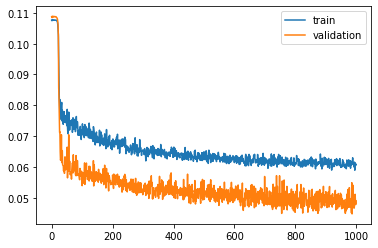

In [10]:
print_result(test_X2, test_y2, lstm_model2, lstm_hist2)

In [11]:
yhat = lstm_model.predict(test_X)
yhat2 = lstm_model2.predict(test_X2)
print_time_series_predicted(test_y, test_indexs, yhat, yhat2, 'NA')

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [12]:
test_y_df = pd.DataFrame(test_y,index=test_indexs, columns=['VALUE'])
yhat_df = pd.DataFrame(yhat, index=test_indexs, columns=['VALUE'])
yhat_df2 = pd.DataFrame(yhat2, index=test_indexs, columns=['VALUE'])
test_y_df.to_csv (r'./datasets/output/test_atteso_na.csv', index = True, header=True, float_format='%.3f')
yhat_df.to_csv (r'./datasets/output/predetto_kpi_na.csv', index = True, header=True, float_format='%.3f')
yhat_df2.to_csv (r'./datasets/output/predetto_no_kpi_na.csv', index = True, header=True, float_format='%.3f')


In [8]:
df_rm=dataset_per_country_code(df,'RM')
train_X, train_y, val_X, val_y, test_X, test_y, test_indexs=split_dataset(df_rm)
lstm_hist, lstm_model=model_lstm(train_X,train_y,val_X, val_y)

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.0
47898.36779999998
Data iniziale: 07-10-2019
Data finale: 02-02-2020
(721, 1, 7) (721,) (81, 1, 7) (81,) (150, 1, 7) (150,)
Train on 721 samples, validate on 81 samples
Epoch 1/1000
 - 2s - loss: 0.1100 - val_loss: 0.1143
Epoch 2/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 3/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 4/1000
 - 0s - loss: 0.1097 - val_loss: 0.1141
Epoch 5/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 6/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 7/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 8/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 9/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 10/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 11/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 12/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 13/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 14/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 15/1000
 - 0s - loss: 0.1097 - val_loss: 0.1141
Epoch 16/1000
 - 0s - loss:

Epoch 149/1000
 - 0s - loss: 0.0482 - val_loss: 0.0271
Epoch 150/1000
 - 0s - loss: 0.0492 - val_loss: 0.0208
Epoch 151/1000
 - 0s - loss: 0.0483 - val_loss: 0.0274
Epoch 152/1000
 - 0s - loss: 0.0480 - val_loss: 0.0185
Epoch 153/1000
 - 0s - loss: 0.0512 - val_loss: 0.0314
Epoch 154/1000
 - 0s - loss: 0.0494 - val_loss: 0.0240
Epoch 155/1000
 - 0s - loss: 0.0487 - val_loss: 0.0259
Epoch 156/1000
 - 0s - loss: 0.0476 - val_loss: 0.0201
Epoch 157/1000
 - 0s - loss: 0.0481 - val_loss: 0.0286
Epoch 158/1000
 - 0s - loss: 0.0491 - val_loss: 0.0220
Epoch 159/1000
 - 0s - loss: 0.0483 - val_loss: 0.0234
Epoch 160/1000
 - 0s - loss: 0.0468 - val_loss: 0.0231
Epoch 161/1000
 - 0s - loss: 0.0464 - val_loss: 0.0231
Epoch 162/1000
 - 0s - loss: 0.0491 - val_loss: 0.0243
Epoch 163/1000
 - 0s - loss: 0.0484 - val_loss: 0.0250
Epoch 164/1000
 - 0s - loss: 0.0472 - val_loss: 0.0263
Epoch 165/1000
 - 0s - loss: 0.0478 - val_loss: 0.0218
Epoch 166/1000
 - 0s - loss: 0.0477 - val_loss: 0.0222
Epoch 167/

Epoch 298/1000
 - 0s - loss: 0.0469 - val_loss: 0.0287
Epoch 299/1000
 - 0s - loss: 0.0453 - val_loss: 0.0238
Epoch 300/1000
 - 0s - loss: 0.0460 - val_loss: 0.0257
Epoch 301/1000
 - 0s - loss: 0.0431 - val_loss: 0.0252
Epoch 302/1000
 - 0s - loss: 0.0439 - val_loss: 0.0248
Epoch 303/1000
 - 0s - loss: 0.0459 - val_loss: 0.0270
Epoch 304/1000
 - 0s - loss: 0.0446 - val_loss: 0.0264
Epoch 305/1000
 - 0s - loss: 0.0430 - val_loss: 0.0301
Epoch 306/1000
 - 0s - loss: 0.0456 - val_loss: 0.0270
Epoch 307/1000
 - 0s - loss: 0.0436 - val_loss: 0.0243
Epoch 308/1000
 - 0s - loss: 0.0456 - val_loss: 0.0310
Epoch 309/1000
 - 0s - loss: 0.0439 - val_loss: 0.0285
Epoch 310/1000
 - 0s - loss: 0.0447 - val_loss: 0.0265
Epoch 311/1000
 - 0s - loss: 0.0431 - val_loss: 0.0235
Epoch 312/1000
 - 0s - loss: 0.0435 - val_loss: 0.0277
Epoch 313/1000
 - 0s - loss: 0.0461 - val_loss: 0.0297
Epoch 314/1000
 - 0s - loss: 0.0444 - val_loss: 0.0237
Epoch 315/1000
 - 0s - loss: 0.0441 - val_loss: 0.0291
Epoch 316/

Epoch 447/1000
 - 0s - loss: 0.0416 - val_loss: 0.0277
Epoch 448/1000
 - 0s - loss: 0.0425 - val_loss: 0.0256
Epoch 449/1000
 - 0s - loss: 0.0424 - val_loss: 0.0258
Epoch 450/1000
 - 0s - loss: 0.0441 - val_loss: 0.0289
Epoch 451/1000
 - 0s - loss: 0.0421 - val_loss: 0.0271
Epoch 452/1000
 - 0s - loss: 0.0423 - val_loss: 0.0287
Epoch 453/1000
 - 0s - loss: 0.0409 - val_loss: 0.0251
Epoch 454/1000
 - 0s - loss: 0.0414 - val_loss: 0.0283
Epoch 455/1000
 - 0s - loss: 0.0446 - val_loss: 0.0289
Epoch 456/1000
 - 0s - loss: 0.0432 - val_loss: 0.0273
Epoch 457/1000
 - 0s - loss: 0.0411 - val_loss: 0.0241
Epoch 458/1000
 - 0s - loss: 0.0415 - val_loss: 0.0272
Epoch 459/1000
 - 0s - loss: 0.0438 - val_loss: 0.0259
Epoch 460/1000
 - 0s - loss: 0.0444 - val_loss: 0.0277
Epoch 461/1000
 - 0s - loss: 0.0420 - val_loss: 0.0264
Epoch 462/1000
 - 0s - loss: 0.0424 - val_loss: 0.0244
Epoch 463/1000
 - 0s - loss: 0.0425 - val_loss: 0.0280
Epoch 464/1000
 - 0s - loss: 0.0420 - val_loss: 0.0252
Epoch 465/

Epoch 596/1000
 - 0s - loss: 0.0409 - val_loss: 0.0237
Epoch 597/1000
 - 0s - loss: 0.0402 - val_loss: 0.0272
Epoch 598/1000
 - 0s - loss: 0.0423 - val_loss: 0.0267
Epoch 599/1000
 - 0s - loss: 0.0421 - val_loss: 0.0246
Epoch 600/1000
 - 0s - loss: 0.0410 - val_loss: 0.0243
Epoch 601/1000
 - 0s - loss: 0.0422 - val_loss: 0.0271
Epoch 602/1000
 - 0s - loss: 0.0415 - val_loss: 0.0257
Epoch 603/1000
 - 0s - loss: 0.0433 - val_loss: 0.0234
Epoch 604/1000
 - 0s - loss: 0.0418 - val_loss: 0.0245
Epoch 605/1000
 - 0s - loss: 0.0420 - val_loss: 0.0219
Epoch 606/1000
 - 0s - loss: 0.0428 - val_loss: 0.0222
Epoch 607/1000
 - 0s - loss: 0.0424 - val_loss: 0.0222
Epoch 608/1000
 - 0s - loss: 0.0420 - val_loss: 0.0260
Epoch 609/1000
 - 0s - loss: 0.0412 - val_loss: 0.0214
Epoch 610/1000
 - 0s - loss: 0.0408 - val_loss: 0.0241
Epoch 611/1000
 - 0s - loss: 0.0434 - val_loss: 0.0241
Epoch 612/1000
 - 0s - loss: 0.0433 - val_loss: 0.0241
Epoch 613/1000
 - 0s - loss: 0.0418 - val_loss: 0.0244
Epoch 614/

Epoch 745/1000
 - 0s - loss: 0.0415 - val_loss: 0.0230
Epoch 746/1000
 - 0s - loss: 0.0410 - val_loss: 0.0279
Epoch 747/1000
 - 0s - loss: 0.0432 - val_loss: 0.0255
Epoch 748/1000
 - 0s - loss: 0.0391 - val_loss: 0.0226
Epoch 749/1000
 - 0s - loss: 0.0409 - val_loss: 0.0242
Epoch 750/1000
 - 0s - loss: 0.0406 - val_loss: 0.0255
Epoch 751/1000
 - 0s - loss: 0.0425 - val_loss: 0.0243
Epoch 752/1000
 - 0s - loss: 0.0405 - val_loss: 0.0241
Epoch 753/1000
 - 0s - loss: 0.0393 - val_loss: 0.0264
Epoch 754/1000
 - 0s - loss: 0.0451 - val_loss: 0.0233
Epoch 755/1000
 - 0s - loss: 0.0423 - val_loss: 0.0233
Epoch 756/1000
 - 0s - loss: 0.0396 - val_loss: 0.0237
Epoch 757/1000
 - 0s - loss: 0.0429 - val_loss: 0.0247
Epoch 758/1000
 - 0s - loss: 0.0403 - val_loss: 0.0262
Epoch 759/1000
 - 0s - loss: 0.0423 - val_loss: 0.0260
Epoch 760/1000
 - 0s - loss: 0.0393 - val_loss: 0.0219
Epoch 761/1000
 - 0s - loss: 0.0421 - val_loss: 0.0249
Epoch 762/1000
 - 0s - loss: 0.0395 - val_loss: 0.0275
Epoch 763/

Epoch 894/1000
 - 0s - loss: 0.0402 - val_loss: 0.0255
Epoch 895/1000
 - 0s - loss: 0.0424 - val_loss: 0.0242
Epoch 896/1000
 - 0s - loss: 0.0394 - val_loss: 0.0244
Epoch 897/1000
 - 0s - loss: 0.0402 - val_loss: 0.0257
Epoch 898/1000
 - 0s - loss: 0.0390 - val_loss: 0.0243
Epoch 899/1000
 - 0s - loss: 0.0408 - val_loss: 0.0267
Epoch 900/1000
 - 0s - loss: 0.0406 - val_loss: 0.0246
Epoch 901/1000
 - 0s - loss: 0.0393 - val_loss: 0.0245
Epoch 902/1000
 - 0s - loss: 0.0392 - val_loss: 0.0250
Epoch 903/1000
 - 0s - loss: 0.0385 - val_loss: 0.0242
Epoch 904/1000
 - 0s - loss: 0.0398 - val_loss: 0.0222
Epoch 905/1000
 - 0s - loss: 0.0407 - val_loss: 0.0237
Epoch 906/1000
 - 0s - loss: 0.0398 - val_loss: 0.0274
Epoch 907/1000
 - 0s - loss: 0.0407 - val_loss: 0.0242
Epoch 908/1000
 - 0s - loss: 0.0409 - val_loss: 0.0255
Epoch 909/1000
 - 0s - loss: 0.0398 - val_loss: 0.0247
Epoch 910/1000
 - 0s - loss: 0.0390 - val_loss: 0.0250
Epoch 911/1000
 - 0s - loss: 0.0394 - val_loss: 0.0233
Epoch 912/

Test RMSE: 0.146
Test MSE: 0.021


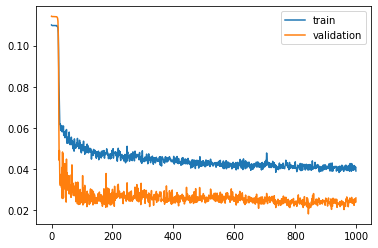

In [14]:
print_result(test_X, test_y, lstm_model, lstm_hist)

In [15]:
#Trainiamo il modello senza il KPI 
df_rm_nokpi=df_rm.drop(['KPI'], axis=1)
train_X2, train_y2, val_X2, val_y2, test_X2, test_y2, test_indexs2=split_dataset(df_rm_nokpi)
lstm_hist2, lstm_model2=model_lstm(train_X2,train_y2,val_X2, val_y2)

Data iniziale: 07-10-2019
Data finale: 02-02-2020
(721, 1, 6) (721,) (81, 1, 6) (81,) (150, 1, 6) (150,)
Train on 721 samples, validate on 81 samples
Epoch 1/1000
 - 2s - loss: 0.1100 - val_loss: 0.1144
Epoch 2/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 3/1000
 - 0s - loss: 0.1098 - val_loss: 0.1142
Epoch 4/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 5/1000
 - 0s - loss: 0.1097 - val_loss: 0.1141
Epoch 6/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 7/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 8/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 9/1000
 - 0s - loss: 0.1099 - val_loss: 0.1141
Epoch 10/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 11/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 12/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 13/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 14/1000
 - 0s - loss: 0.1097 - val_loss: 0.1141
Epoch 15/1000
 - 0s - loss: 0.1098 - val_loss: 0.1141
Epoch 16/1000
 - 0s - loss: 0.1097 - val_loss: 0.

 - 0s - loss: 0.0503 - val_loss: 0.0371
Epoch 150/1000
 - 0s - loss: 0.0507 - val_loss: 0.0374
Epoch 151/1000
 - 0s - loss: 0.0503 - val_loss: 0.0362
Epoch 152/1000
 - 0s - loss: 0.0511 - val_loss: 0.0378
Epoch 153/1000
 - 0s - loss: 0.0488 - val_loss: 0.0339
Epoch 154/1000
 - 0s - loss: 0.0526 - val_loss: 0.0449
Epoch 155/1000
 - 0s - loss: 0.0504 - val_loss: 0.0357
Epoch 156/1000
 - 0s - loss: 0.0528 - val_loss: 0.0368
Epoch 157/1000
 - 0s - loss: 0.0524 - val_loss: 0.0377
Epoch 158/1000
 - 0s - loss: 0.0497 - val_loss: 0.0379
Epoch 159/1000
 - 0s - loss: 0.0506 - val_loss: 0.0371
Epoch 160/1000
 - 0s - loss: 0.0513 - val_loss: 0.0382
Epoch 161/1000
 - 0s - loss: 0.0503 - val_loss: 0.0338
Epoch 162/1000
 - 0s - loss: 0.0496 - val_loss: 0.0363
Epoch 163/1000
 - 0s - loss: 0.0516 - val_loss: 0.0368
Epoch 164/1000
 - 0s - loss: 0.0495 - val_loss: 0.0376
Epoch 165/1000
 - 0s - loss: 0.0505 - val_loss: 0.0358
Epoch 166/1000
 - 0s - loss: 0.0498 - val_loss: 0.0408
Epoch 167/1000
 - 0s - lo

 - 0s - loss: 0.0489 - val_loss: 0.0360
Epoch 299/1000
 - 0s - loss: 0.0495 - val_loss: 0.0349
Epoch 300/1000
 - 0s - loss: 0.0479 - val_loss: 0.0347
Epoch 301/1000
 - 0s - loss: 0.0494 - val_loss: 0.0357
Epoch 302/1000
 - 0s - loss: 0.0495 - val_loss: 0.0368
Epoch 303/1000
 - 0s - loss: 0.0495 - val_loss: 0.0386
Epoch 304/1000
 - 0s - loss: 0.0477 - val_loss: 0.0379
Epoch 305/1000
 - 0s - loss: 0.0480 - val_loss: 0.0386
Epoch 306/1000
 - 0s - loss: 0.0492 - val_loss: 0.0336
Epoch 307/1000
 - 0s - loss: 0.0485 - val_loss: 0.0371
Epoch 308/1000
 - 0s - loss: 0.0501 - val_loss: 0.0358
Epoch 309/1000
 - 0s - loss: 0.0461 - val_loss: 0.0342
Epoch 310/1000
 - 0s - loss: 0.0498 - val_loss: 0.0360
Epoch 311/1000
 - 0s - loss: 0.0461 - val_loss: 0.0357
Epoch 312/1000
 - 0s - loss: 0.0485 - val_loss: 0.0354
Epoch 313/1000
 - 0s - loss: 0.0494 - val_loss: 0.0350
Epoch 314/1000
 - 0s - loss: 0.0487 - val_loss: 0.0349
Epoch 315/1000
 - 0s - loss: 0.0473 - val_loss: 0.0362
Epoch 316/1000
 - 0s - lo

 - 0s - loss: 0.0467 - val_loss: 0.0360
Epoch 448/1000
 - 0s - loss: 0.0463 - val_loss: 0.0372
Epoch 449/1000
 - 0s - loss: 0.0470 - val_loss: 0.0369
Epoch 450/1000
 - 0s - loss: 0.0474 - val_loss: 0.0347
Epoch 451/1000
 - 0s - loss: 0.0494 - val_loss: 0.0379
Epoch 452/1000
 - 0s - loss: 0.0475 - val_loss: 0.0352
Epoch 453/1000
 - 0s - loss: 0.0460 - val_loss: 0.0350
Epoch 454/1000
 - 0s - loss: 0.0459 - val_loss: 0.0348
Epoch 455/1000
 - 0s - loss: 0.0472 - val_loss: 0.0346
Epoch 456/1000
 - 0s - loss: 0.0474 - val_loss: 0.0341
Epoch 457/1000
 - 0s - loss: 0.0479 - val_loss: 0.0341
Epoch 458/1000
 - 0s - loss: 0.0474 - val_loss: 0.0345
Epoch 459/1000
 - 0s - loss: 0.0467 - val_loss: 0.0349
Epoch 460/1000
 - 0s - loss: 0.0480 - val_loss: 0.0374
Epoch 461/1000
 - 0s - loss: 0.0467 - val_loss: 0.0390
Epoch 462/1000
 - 0s - loss: 0.0465 - val_loss: 0.0361
Epoch 463/1000
 - 0s - loss: 0.0471 - val_loss: 0.0372
Epoch 464/1000
 - 0s - loss: 0.0474 - val_loss: 0.0371
Epoch 465/1000
 - 0s - lo

 - 0s - loss: 0.0471 - val_loss: 0.0371
Epoch 597/1000
 - 0s - loss: 0.0450 - val_loss: 0.0370
Epoch 598/1000
 - 0s - loss: 0.0469 - val_loss: 0.0376
Epoch 599/1000
 - 0s - loss: 0.0456 - val_loss: 0.0365
Epoch 600/1000
 - 0s - loss: 0.0482 - val_loss: 0.0356
Epoch 601/1000
 - 0s - loss: 0.0483 - val_loss: 0.0338
Epoch 602/1000
 - 0s - loss: 0.0478 - val_loss: 0.0354
Epoch 603/1000
 - 0s - loss: 0.0461 - val_loss: 0.0363
Epoch 604/1000
 - 0s - loss: 0.0470 - val_loss: 0.0348
Epoch 605/1000
 - 0s - loss: 0.0462 - val_loss: 0.0356
Epoch 606/1000
 - 0s - loss: 0.0473 - val_loss: 0.0381
Epoch 607/1000
 - 0s - loss: 0.0474 - val_loss: 0.0376
Epoch 608/1000
 - 0s - loss: 0.0468 - val_loss: 0.0353
Epoch 609/1000
 - 0s - loss: 0.0454 - val_loss: 0.0363
Epoch 610/1000
 - 0s - loss: 0.0469 - val_loss: 0.0351
Epoch 611/1000
 - 0s - loss: 0.0466 - val_loss: 0.0382
Epoch 612/1000
 - 0s - loss: 0.0471 - val_loss: 0.0381
Epoch 613/1000
 - 0s - loss: 0.0472 - val_loss: 0.0361
Epoch 614/1000
 - 0s - lo

 - 0s - loss: 0.0468 - val_loss: 0.0362
Epoch 746/1000
 - 0s - loss: 0.0458 - val_loss: 0.0334
Epoch 747/1000
 - 0s - loss: 0.0472 - val_loss: 0.0346
Epoch 748/1000
 - 0s - loss: 0.0467 - val_loss: 0.0349
Epoch 749/1000
 - 0s - loss: 0.0473 - val_loss: 0.0344
Epoch 750/1000
 - 0s - loss: 0.0477 - val_loss: 0.0360
Epoch 751/1000
 - 0s - loss: 0.0482 - val_loss: 0.0391
Epoch 752/1000
 - 0s - loss: 0.0462 - val_loss: 0.0360
Epoch 753/1000
 - 0s - loss: 0.0470 - val_loss: 0.0343
Epoch 754/1000
 - 0s - loss: 0.0465 - val_loss: 0.0353
Epoch 755/1000
 - 0s - loss: 0.0468 - val_loss: 0.0357
Epoch 756/1000
 - 0s - loss: 0.0463 - val_loss: 0.0359
Epoch 757/1000
 - 0s - loss: 0.0450 - val_loss: 0.0365
Epoch 758/1000
 - 0s - loss: 0.0448 - val_loss: 0.0371
Epoch 759/1000
 - 0s - loss: 0.0470 - val_loss: 0.0371
Epoch 760/1000
 - 0s - loss: 0.0464 - val_loss: 0.0363
Epoch 761/1000
 - 0s - loss: 0.0451 - val_loss: 0.0376
Epoch 762/1000
 - 0s - loss: 0.0471 - val_loss: 0.0381
Epoch 763/1000
 - 0s - lo

 - 0s - loss: 0.0453 - val_loss: 0.0345
Epoch 895/1000
 - 0s - loss: 0.0447 - val_loss: 0.0375
Epoch 896/1000
 - 0s - loss: 0.0465 - val_loss: 0.0394
Epoch 897/1000
 - 0s - loss: 0.0456 - val_loss: 0.0380
Epoch 898/1000
 - 0s - loss: 0.0466 - val_loss: 0.0353
Epoch 899/1000
 - 0s - loss: 0.0454 - val_loss: 0.0346
Epoch 900/1000
 - 0s - loss: 0.0447 - val_loss: 0.0353
Epoch 901/1000
 - 0s - loss: 0.0469 - val_loss: 0.0345
Epoch 902/1000
 - 0s - loss: 0.0482 - val_loss: 0.0359
Epoch 903/1000
 - 0s - loss: 0.0461 - val_loss: 0.0362
Epoch 904/1000
 - 0s - loss: 0.0476 - val_loss: 0.0356
Epoch 905/1000
 - 0s - loss: 0.0456 - val_loss: 0.0377
Epoch 906/1000
 - 0s - loss: 0.0472 - val_loss: 0.0378
Epoch 907/1000
 - 0s - loss: 0.0453 - val_loss: 0.0390
Epoch 908/1000
 - 0s - loss: 0.0476 - val_loss: 0.0379
Epoch 909/1000
 - 0s - loss: 0.0459 - val_loss: 0.0370
Epoch 910/1000
 - 0s - loss: 0.0474 - val_loss: 0.0375
Epoch 911/1000
 - 0s - loss: 0.0460 - val_loss: 0.0366
Epoch 912/1000
 - 0s - lo

Test RMSE: 0.137
Test MSE: 0.019


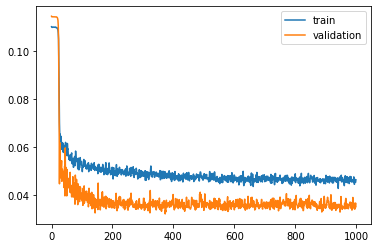

In [16]:
print_result(test_X2, test_y2, lstm_model2, lstm_hist2)

In [17]:
yhat = lstm_model.predict(test_X)
yhat2 = lstm_model2.predict(test_X2)
print_time_series_predicted(test_y, test_indexs, yhat, yhat2, 'RM')

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [18]:
test_y_df = pd.DataFrame(test_y,index=test_indexs, columns=['VALUE'])
yhat_df = pd.DataFrame(yhat, index=test_indexs, columns=['VALUE'])
yhat_df2 = pd.DataFrame(yhat2, index=test_indexs, columns=['VALUE'])
test_y_df.to_csv (r'./datasets/output/test_atteso_rm.csv', index = True, header=True, float_format='%.3f')
yhat_df.to_csv (r'./datasets/output/predetto_kpi_rm.csv', index = True, header=True, float_format='%.3f')
yhat_df2.to_csv (r'./datasets/output/predetto_no_kpi_rm.csv', index = True, header=True, float_format='%.3f')

In [10]:
df = pd.read_csv('./datasets/to_train.csv', keep_default_na=False, na_values=['_'])
df.drop('REGIONE',axis=1,inplace=True)
df_mi=dataset_per_country_code(df,'MI')
train_X, train_y, val_X, val_y, test_X, test_y, test_indexs=split_dataset(df_mi)
lstm_hist, lstm_model=model_lstm(train_X,train_y,val_X, val_y)

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0.0
34797.579300000005
Data iniziale: 07-10-2019
Data finale: 02-02-2020
(721, 1, 7) (721,) (81, 1, 7) (81,) (150, 1, 7) (150,)
Train on 721 samples, validate on 81 samples
Epoch 1/1000
 - 3s - loss: 0.1104 - val_loss: 0.1290
Epoch 2/1000
 - 1s - loss: 0.1105 - val_loss: 0.1283
Epoch 3/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 4/1000
 - 1s - loss: 0.1105 - val_loss: 0.1283
Epoch 5/1000
 - 0s - loss: 0.1104 - val_loss: 0.1283
Epoch 6/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 7/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 8/1000
 - 0s - loss: 0.1104 - val_loss: 0.1283
Epoch 9/1000
 - 0s - loss: 0.1104 - val_loss: 0.1283
Epoch 10/1000
 - 1s - loss: 0.1104 - val_loss: 0.1283
Epoch 11/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 12/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 13/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 14/1000
 - 1s - loss: 0.1105 - val_loss: 0.1283
Epoch 15/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 16/1000
 - 0s - loss

Epoch 149/1000
 - 0s - loss: 0.0446 - val_loss: 0.0638
Epoch 150/1000
 - 0s - loss: 0.0442 - val_loss: 0.0588
Epoch 151/1000
 - 0s - loss: 0.0453 - val_loss: 0.0649
Epoch 152/1000
 - 0s - loss: 0.0440 - val_loss: 0.0626
Epoch 153/1000
 - 0s - loss: 0.0418 - val_loss: 0.0563
Epoch 154/1000
 - 0s - loss: 0.0466 - val_loss: 0.0649
Epoch 155/1000
 - 0s - loss: 0.0444 - val_loss: 0.0622
Epoch 156/1000
 - 0s - loss: 0.0449 - val_loss: 0.0635
Epoch 157/1000
 - 0s - loss: 0.0425 - val_loss: 0.0601
Epoch 158/1000
 - 0s - loss: 0.0425 - val_loss: 0.0629
Epoch 159/1000
 - 0s - loss: 0.0426 - val_loss: 0.0618
Epoch 160/1000
 - 0s - loss: 0.0439 - val_loss: 0.0621
Epoch 161/1000
 - 0s - loss: 0.0437 - val_loss: 0.0596
Epoch 162/1000
 - 0s - loss: 0.0451 - val_loss: 0.0633
Epoch 163/1000
 - 1s - loss: 0.0421 - val_loss: 0.0612
Epoch 164/1000
 - 1s - loss: 0.0438 - val_loss: 0.0627
Epoch 165/1000
 - 1s - loss: 0.0428 - val_loss: 0.0620
Epoch 166/1000
 - 0s - loss: 0.0430 - val_loss: 0.0635
Epoch 167/

Epoch 298/1000
 - 0s - loss: 0.0436 - val_loss: 0.0616
Epoch 299/1000
 - 0s - loss: 0.0421 - val_loss: 0.0618
Epoch 300/1000
 - 0s - loss: 0.0425 - val_loss: 0.0639
Epoch 301/1000
 - 0s - loss: 0.0406 - val_loss: 0.0593
Epoch 302/1000
 - 0s - loss: 0.0435 - val_loss: 0.0661
Epoch 303/1000
 - 0s - loss: 0.0423 - val_loss: 0.0629
Epoch 304/1000
 - 0s - loss: 0.0426 - val_loss: 0.0611
Epoch 305/1000
 - 0s - loss: 0.0423 - val_loss: 0.0621
Epoch 306/1000
 - 0s - loss: 0.0405 - val_loss: 0.0617
Epoch 307/1000
 - 0s - loss: 0.0415 - val_loss: 0.0631
Epoch 308/1000
 - 0s - loss: 0.0414 - val_loss: 0.0632
Epoch 309/1000
 - 0s - loss: 0.0420 - val_loss: 0.0619
Epoch 310/1000
 - 0s - loss: 0.0410 - val_loss: 0.0627
Epoch 311/1000
 - 0s - loss: 0.0415 - val_loss: 0.0621
Epoch 312/1000
 - 0s - loss: 0.0411 - val_loss: 0.0606
Epoch 313/1000
 - 0s - loss: 0.0439 - val_loss: 0.0619
Epoch 314/1000
 - 0s - loss: 0.0418 - val_loss: 0.0610
Epoch 315/1000
 - 1s - loss: 0.0416 - val_loss: 0.0631
Epoch 316/

Epoch 447/1000
 - 0s - loss: 0.0413 - val_loss: 0.0619
Epoch 448/1000
 - 0s - loss: 0.0387 - val_loss: 0.0628
Epoch 449/1000
 - 0s - loss: 0.0388 - val_loss: 0.0648
Epoch 450/1000
 - 0s - loss: 0.0400 - val_loss: 0.0601
Epoch 451/1000
 - 0s - loss: 0.0411 - val_loss: 0.0650
Epoch 452/1000
 - 0s - loss: 0.0392 - val_loss: 0.0639
Epoch 453/1000
 - 0s - loss: 0.0388 - val_loss: 0.0630
Epoch 454/1000
 - 0s - loss: 0.0400 - val_loss: 0.0638
Epoch 455/1000
 - 0s - loss: 0.0397 - val_loss: 0.0656
Epoch 456/1000
 - 0s - loss: 0.0417 - val_loss: 0.0613
Epoch 457/1000
 - 0s - loss: 0.0411 - val_loss: 0.0613
Epoch 458/1000
 - 1s - loss: 0.0390 - val_loss: 0.0636
Epoch 459/1000
 - 0s - loss: 0.0417 - val_loss: 0.0642
Epoch 460/1000
 - 0s - loss: 0.0403 - val_loss: 0.0620
Epoch 461/1000
 - 0s - loss: 0.0385 - val_loss: 0.0618
Epoch 462/1000
 - 0s - loss: 0.0422 - val_loss: 0.0647
Epoch 463/1000
 - 0s - loss: 0.0391 - val_loss: 0.0641
Epoch 464/1000
 - 1s - loss: 0.0411 - val_loss: 0.0600
Epoch 465/

Epoch 596/1000
 - 0s - loss: 0.0382 - val_loss: 0.0625
Epoch 597/1000
 - 0s - loss: 0.0386 - val_loss: 0.0618
Epoch 598/1000
 - 0s - loss: 0.0380 - val_loss: 0.0622
Epoch 599/1000
 - 0s - loss: 0.0417 - val_loss: 0.0627
Epoch 600/1000
 - 0s - loss: 0.0380 - val_loss: 0.0579
Epoch 601/1000
 - 0s - loss: 0.0402 - val_loss: 0.0634
Epoch 602/1000
 - 0s - loss: 0.0402 - val_loss: 0.0607
Epoch 603/1000
 - 0s - loss: 0.0393 - val_loss: 0.0606
Epoch 604/1000
 - 0s - loss: 0.0395 - val_loss: 0.0637
Epoch 605/1000
 - 0s - loss: 0.0389 - val_loss: 0.0613
Epoch 606/1000
 - 0s - loss: 0.0395 - val_loss: 0.0618
Epoch 607/1000
 - 0s - loss: 0.0385 - val_loss: 0.0624
Epoch 608/1000
 - 0s - loss: 0.0390 - val_loss: 0.0614
Epoch 609/1000
 - 0s - loss: 0.0392 - val_loss: 0.0617
Epoch 610/1000
 - 0s - loss: 0.0390 - val_loss: 0.0608
Epoch 611/1000
 - 0s - loss: 0.0386 - val_loss: 0.0626
Epoch 612/1000
 - 0s - loss: 0.0394 - val_loss: 0.0616
Epoch 613/1000
 - 0s - loss: 0.0394 - val_loss: 0.0626
Epoch 614/

Epoch 745/1000
 - 0s - loss: 0.0403 - val_loss: 0.0613
Epoch 746/1000
 - 0s - loss: 0.0380 - val_loss: 0.0634
Epoch 747/1000
 - 0s - loss: 0.0397 - val_loss: 0.0592
Epoch 748/1000
 - 0s - loss: 0.0385 - val_loss: 0.0628
Epoch 749/1000
 - 0s - loss: 0.0388 - val_loss: 0.0616
Epoch 750/1000
 - 0s - loss: 0.0391 - val_loss: 0.0606
Epoch 751/1000
 - 0s - loss: 0.0384 - val_loss: 0.0609
Epoch 752/1000
 - 0s - loss: 0.0387 - val_loss: 0.0623
Epoch 753/1000
 - 0s - loss: 0.0389 - val_loss: 0.0611
Epoch 754/1000
 - 0s - loss: 0.0387 - val_loss: 0.0631
Epoch 755/1000
 - 0s - loss: 0.0382 - val_loss: 0.0594
Epoch 756/1000
 - 0s - loss: 0.0401 - val_loss: 0.0671
Epoch 757/1000
 - 0s - loss: 0.0406 - val_loss: 0.0615
Epoch 758/1000
 - 0s - loss: 0.0376 - val_loss: 0.0631
Epoch 759/1000
 - 0s - loss: 0.0379 - val_loss: 0.0627
Epoch 760/1000
 - 0s - loss: 0.0398 - val_loss: 0.0598
Epoch 761/1000
 - 0s - loss: 0.0386 - val_loss: 0.0625
Epoch 762/1000
 - 0s - loss: 0.0386 - val_loss: 0.0625
Epoch 763/

Epoch 894/1000
 - 1s - loss: 0.0383 - val_loss: 0.0641
Epoch 895/1000
 - 1s - loss: 0.0379 - val_loss: 0.0596
Epoch 896/1000
 - 1s - loss: 0.0377 - val_loss: 0.0624
Epoch 897/1000
 - 1s - loss: 0.0364 - val_loss: 0.0624
Epoch 898/1000
 - 1s - loss: 0.0378 - val_loss: 0.0624
Epoch 899/1000
 - 1s - loss: 0.0398 - val_loss: 0.0600
Epoch 900/1000
 - 1s - loss: 0.0388 - val_loss: 0.0643
Epoch 901/1000
 - 0s - loss: 0.0390 - val_loss: 0.0591
Epoch 902/1000
 - 1s - loss: 0.0382 - val_loss: 0.0625
Epoch 903/1000
 - 0s - loss: 0.0386 - val_loss: 0.0606
Epoch 904/1000
 - 0s - loss: 0.0376 - val_loss: 0.0633
Epoch 905/1000
 - 0s - loss: 0.0379 - val_loss: 0.0621
Epoch 906/1000
 - 0s - loss: 0.0389 - val_loss: 0.0612
Epoch 907/1000
 - 0s - loss: 0.0366 - val_loss: 0.0607
Epoch 908/1000
 - 0s - loss: 0.0379 - val_loss: 0.0631
Epoch 909/1000
 - 0s - loss: 0.0377 - val_loss: 0.0607
Epoch 910/1000
 - 0s - loss: 0.0390 - val_loss: 0.0614
Epoch 911/1000
 - 0s - loss: 0.0401 - val_loss: 0.0621
Epoch 912/

Test RMSE: 0.157
Test MSE: 0.025


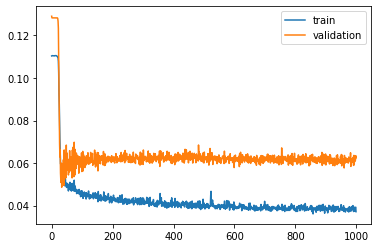

In [11]:
print_result(test_X, test_y, lstm_model, lstm_hist)

In [12]:
#Trainiamo il modello senza il KPI 
df_mi_nokpi=df_mi.drop(['KPI'], axis=1)
train_X2, train_y2, val_X2, val_y2, test_X2, test_y2, test_indexs2=split_dataset(df_mi_nokpi)
lstm_hist2, lstm_model2=model_lstm(train_X2,train_y2,val_X2, val_y2)

Data iniziale: 07-10-2019
Data finale: 02-02-2020
(721, 1, 6) (721,) (81, 1, 6) (81,) (150, 1, 6) (150,)
Train on 721 samples, validate on 81 samples
Epoch 1/1000
 - 5s - loss: 0.1104 - val_loss: 0.1292
Epoch 2/1000
 - 0s - loss: 0.1104 - val_loss: 0.1283
Epoch 3/1000
 - 0s - loss: 0.1106 - val_loss: 0.1283
Epoch 4/1000
 - 0s - loss: 0.1106 - val_loss: 0.1283
Epoch 5/1000
 - 0s - loss: 0.1104 - val_loss: 0.1283
Epoch 6/1000
 - 0s - loss: 0.1104 - val_loss: 0.1283
Epoch 7/1000
 - 0s - loss: 0.1106 - val_loss: 0.1283
Epoch 8/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 9/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 10/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 11/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 12/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 13/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 14/1000
 - 0s - loss: 0.1105 - val_loss: 0.1283
Epoch 15/1000
 - 0s - loss: 0.1104 - val_loss: 0.1283
Epoch 16/1000
 - 0s - loss: 0.1103 - val_loss: 0.

 - 0s - loss: 0.0492 - val_loss: 0.0701
Epoch 150/1000
 - 0s - loss: 0.0483 - val_loss: 0.0678
Epoch 151/1000
 - 0s - loss: 0.0495 - val_loss: 0.0695
Epoch 152/1000
 - 0s - loss: 0.0505 - val_loss: 0.0689
Epoch 153/1000
 - 0s - loss: 0.0497 - val_loss: 0.0689
Epoch 154/1000
 - 0s - loss: 0.0495 - val_loss: 0.0691
Epoch 155/1000
 - 1s - loss: 0.0485 - val_loss: 0.0677
Epoch 156/1000
 - 0s - loss: 0.0507 - val_loss: 0.0679
Epoch 157/1000
 - 0s - loss: 0.0491 - val_loss: 0.0705
Epoch 158/1000
 - 0s - loss: 0.0495 - val_loss: 0.0710
Epoch 159/1000
 - 0s - loss: 0.0483 - val_loss: 0.0692
Epoch 160/1000
 - 0s - loss: 0.0525 - val_loss: 0.0750
Epoch 161/1000
 - 0s - loss: 0.0512 - val_loss: 0.0674
Epoch 162/1000
 - 0s - loss: 0.0522 - val_loss: 0.0689
Epoch 163/1000
 - 0s - loss: 0.0491 - val_loss: 0.0702
Epoch 164/1000
 - 0s - loss: 0.0489 - val_loss: 0.0684
Epoch 165/1000
 - 0s - loss: 0.0496 - val_loss: 0.0745
Epoch 166/1000
 - 0s - loss: 0.0495 - val_loss: 0.0674
Epoch 167/1000
 - 0s - lo

 - 0s - loss: 0.0493 - val_loss: 0.0708
Epoch 299/1000
 - 0s - loss: 0.0495 - val_loss: 0.0695
Epoch 300/1000
 - 0s - loss: 0.0465 - val_loss: 0.0700
Epoch 301/1000
 - 0s - loss: 0.0458 - val_loss: 0.0699
Epoch 302/1000
 - 0s - loss: 0.0474 - val_loss: 0.0712
Epoch 303/1000
 - 0s - loss: 0.0467 - val_loss: 0.0718
Epoch 304/1000
 - 0s - loss: 0.0484 - val_loss: 0.0678
Epoch 305/1000
 - 0s - loss: 0.0500 - val_loss: 0.0714
Epoch 306/1000
 - 0s - loss: 0.0466 - val_loss: 0.0708
Epoch 307/1000
 - 0s - loss: 0.0483 - val_loss: 0.0672
Epoch 308/1000
 - 0s - loss: 0.0489 - val_loss: 0.0703
Epoch 309/1000
 - 0s - loss: 0.0474 - val_loss: 0.0728
Epoch 310/1000
 - 0s - loss: 0.0473 - val_loss: 0.0685
Epoch 311/1000
 - 0s - loss: 0.0479 - val_loss: 0.0695
Epoch 312/1000
 - 0s - loss: 0.0471 - val_loss: 0.0701
Epoch 313/1000
 - 0s - loss: 0.0462 - val_loss: 0.0680
Epoch 314/1000
 - 1s - loss: 0.0481 - val_loss: 0.0711
Epoch 315/1000
 - 1s - loss: 0.0476 - val_loss: 0.0699
Epoch 316/1000
 - 0s - lo

 - 1s - loss: 0.0464 - val_loss: 0.0704
Epoch 448/1000
 - 1s - loss: 0.0469 - val_loss: 0.0671
Epoch 449/1000
 - 1s - loss: 0.0459 - val_loss: 0.0700
Epoch 450/1000
 - 1s - loss: 0.0480 - val_loss: 0.0704
Epoch 451/1000
 - 1s - loss: 0.0462 - val_loss: 0.0698
Epoch 452/1000
 - 1s - loss: 0.0468 - val_loss: 0.0702
Epoch 453/1000
 - 1s - loss: 0.0457 - val_loss: 0.0687
Epoch 454/1000
 - 1s - loss: 0.0464 - val_loss: 0.0700
Epoch 455/1000
 - 1s - loss: 0.0471 - val_loss: 0.0689
Epoch 456/1000
 - 1s - loss: 0.0472 - val_loss: 0.0706
Epoch 457/1000
 - 1s - loss: 0.0443 - val_loss: 0.0674
Epoch 458/1000
 - 1s - loss: 0.0462 - val_loss: 0.0714
Epoch 459/1000
 - 1s - loss: 0.0493 - val_loss: 0.0682
Epoch 460/1000
 - 1s - loss: 0.0457 - val_loss: 0.0687
Epoch 461/1000
 - 1s - loss: 0.0467 - val_loss: 0.0695
Epoch 462/1000
 - 1s - loss: 0.0464 - val_loss: 0.0695
Epoch 463/1000
 - 1s - loss: 0.0445 - val_loss: 0.0695
Epoch 464/1000
 - 1s - loss: 0.0480 - val_loss: 0.0694
Epoch 465/1000
 - 1s - lo

 - 1s - loss: 0.0483 - val_loss: 0.0715
Epoch 597/1000
 - 1s - loss: 0.0443 - val_loss: 0.0702
Epoch 598/1000
 - 0s - loss: 0.0453 - val_loss: 0.0700
Epoch 599/1000
 - 0s - loss: 0.0460 - val_loss: 0.0705
Epoch 600/1000
 - 0s - loss: 0.0455 - val_loss: 0.0703
Epoch 601/1000
 - 1s - loss: 0.0452 - val_loss: 0.0694
Epoch 602/1000
 - 1s - loss: 0.0466 - val_loss: 0.0720
Epoch 603/1000
 - 1s - loss: 0.0450 - val_loss: 0.0697
Epoch 604/1000
 - 0s - loss: 0.0456 - val_loss: 0.0705
Epoch 605/1000
 - 1s - loss: 0.0455 - val_loss: 0.0706
Epoch 606/1000
 - 0s - loss: 0.0453 - val_loss: 0.0678
Epoch 607/1000
 - 1s - loss: 0.0452 - val_loss: 0.0705
Epoch 608/1000
 - 0s - loss: 0.0450 - val_loss: 0.0704
Epoch 609/1000
 - 0s - loss: 0.0470 - val_loss: 0.0719
Epoch 610/1000
 - 0s - loss: 0.0457 - val_loss: 0.0688
Epoch 611/1000
 - 0s - loss: 0.0448 - val_loss: 0.0697
Epoch 612/1000
 - 0s - loss: 0.0463 - val_loss: 0.0701
Epoch 613/1000
 - 0s - loss: 0.0465 - val_loss: 0.0696
Epoch 614/1000
 - 0s - lo

 - 0s - loss: 0.0435 - val_loss: 0.0712
Epoch 746/1000
 - 1s - loss: 0.0455 - val_loss: 0.0694
Epoch 747/1000
 - 0s - loss: 0.0446 - val_loss: 0.0695
Epoch 748/1000
 - 0s - loss: 0.0457 - val_loss: 0.0706
Epoch 749/1000
 - 0s - loss: 0.0453 - val_loss: 0.0690
Epoch 750/1000
 - 0s - loss: 0.0458 - val_loss: 0.0700
Epoch 751/1000
 - 0s - loss: 0.0452 - val_loss: 0.0711
Epoch 752/1000
 - 0s - loss: 0.0435 - val_loss: 0.0705
Epoch 753/1000
 - 0s - loss: 0.0469 - val_loss: 0.0712
Epoch 754/1000
 - 0s - loss: 0.0457 - val_loss: 0.0709
Epoch 755/1000
 - 0s - loss: 0.0458 - val_loss: 0.0690
Epoch 756/1000
 - 0s - loss: 0.0448 - val_loss: 0.0681
Epoch 757/1000
 - 0s - loss: 0.0456 - val_loss: 0.0721
Epoch 758/1000
 - 0s - loss: 0.0452 - val_loss: 0.0700
Epoch 759/1000
 - 0s - loss: 0.0451 - val_loss: 0.0696
Epoch 760/1000
 - 0s - loss: 0.0438 - val_loss: 0.0684
Epoch 761/1000
 - 0s - loss: 0.0458 - val_loss: 0.0705
Epoch 762/1000
 - 1s - loss: 0.0457 - val_loss: 0.0710
Epoch 763/1000
 - 0s - lo

 - 0s - loss: 0.0432 - val_loss: 0.0696
Epoch 895/1000
 - 0s - loss: 0.0448 - val_loss: 0.0685
Epoch 896/1000
 - 0s - loss: 0.0451 - val_loss: 0.0730
Epoch 897/1000
 - 0s - loss: 0.0448 - val_loss: 0.0692
Epoch 898/1000
 - 0s - loss: 0.0452 - val_loss: 0.0699
Epoch 899/1000
 - 0s - loss: 0.0447 - val_loss: 0.0712
Epoch 900/1000
 - 0s - loss: 0.0432 - val_loss: 0.0714
Epoch 901/1000
 - 0s - loss: 0.0430 - val_loss: 0.0683
Epoch 902/1000
 - 0s - loss: 0.0450 - val_loss: 0.0737
Epoch 903/1000
 - 0s - loss: 0.0435 - val_loss: 0.0698
Epoch 904/1000
 - 0s - loss: 0.0453 - val_loss: 0.0709
Epoch 905/1000
 - 0s - loss: 0.0455 - val_loss: 0.0700
Epoch 906/1000
 - 0s - loss: 0.0440 - val_loss: 0.0712
Epoch 907/1000
 - 0s - loss: 0.0442 - val_loss: 0.0709
Epoch 908/1000
 - 0s - loss: 0.0449 - val_loss: 0.0717
Epoch 909/1000
 - 0s - loss: 0.0453 - val_loss: 0.0721
Epoch 910/1000
 - 0s - loss: 0.0435 - val_loss: 0.0702
Epoch 911/1000
 - 0s - loss: 0.0444 - val_loss: 0.0708
Epoch 912/1000
 - 0s - lo

Test RMSE: 0.166
Test MSE: 0.027


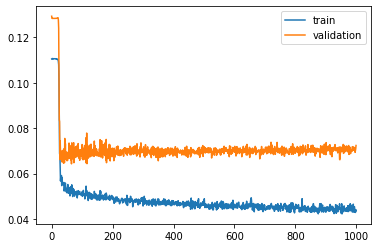

In [13]:
print_result(test_X2, test_y2, lstm_model2, lstm_hist2)

In [14]:
yhat = lstm_model.predict(test_X)
yhat2 = lstm_model2.predict(test_X2)
print_time_series_predicted(test_y, test_indexs, yhat, yhat2, 'MI')

C:\Users\ant.pagano\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [15]:
test_y_df = pd.DataFrame(test_y,index=test_indexs, columns=['VALUE'])
yhat_df = pd.DataFrame(yhat, index=test_indexs, columns=['VALUE'])
yhat_df2 = pd.DataFrame(yhat2, index=test_indexs, columns=['VALUE'])
test_y_df.to_csv (r'./datasets/output/test_atteso_mi.csv', index = True, header=True, float_format='%.3f')
yhat_df.to_csv (r'./datasets/output/predetto_kpi_mi.csv', index = True, header=True, float_format='%.3f')
yhat_df2.to_csv (r'./datasets/output/predetto_no_kpi_mi.csv', index = True, header=True, float_format='%.3f')